Confirmed by Omar

---

## üìä Datasets Overview

### 1. üü® NYC Taxi Fare Prediction
- **Task:** Regression
- **Source:** [Kaggle - NYC Taxi Fare Prediction](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction)
- **Size:** 55M+ rows (Kaggle version)
- **Description:** Predict taxi fare based on pickup/dropoff location, time, and passenger count.
---

## üì¶ Install Required Packages

In [1]:
!pip install dask==2024.12.1 distributed==2024.12.1 -q
!pip install dask-ml -q
!pip install dask-cudf-cu12==25.2.0 rmm-cu12==25.2.0 cudf-cu12==25.2.0 pylibraft-cu12==25.2.0 rapids-dask-dependency==25.2.0 -q
!pip install seaborn -q
!pip install rich -q
!pip install catboost -q
!nvidia-smi

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.21 requires dask==2024.12.1, but you have dask 2025.3.0 which is incompatible.
rapids-dask-dependency 25.2.0 requires dask==2024.12.1, but you have dask 2025.3.0 which is incompatible.
rapids-dask-dependency 25.2.0 requires distributed==2024.12.1, but you have distributed 2025.3.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-ml 2025.1.0 requires dask[array,dataframe]>=2025.1.0, but you have dask 2024.12.1 which is incompatible.
dask-ml 2025.1.0 requires distributed>=2025.1.0, but you have distributed 2024.12.1 which is incompatible.
Thu Apr 17 15:26:39 2025       
+---------------------------------------------------------------------------------

## üé® Setup Rich Console

In [2]:
from rich.console import Console, Group
from rich.style import Style
from rich.panel import Panel
from rich.text import Text
from rich.table import Table
from rich import box
import torch
import re

console = Console()

def highlight_keywords(text: str, keyword_style="bold bright_cyan", default_style="bright_white") -> Text:
    keywords = ["train_df", "test_df", "submission", "device", "cuda", "cpu",
            "DataFrame", "Client", "processes", "threads", "memory",
            "fare_amount", "pickup_longitude", "pickup_latitude",
            "dropoff_longitude", "dropoff_latitude", "passenger_count",
            "hour", "day", "month", "year", "weekday", "is_weekend", "is_night", "rush_hour", "distance"]
    pattern = r'\b(' + '|'.join(re.escape(k) for k in keywords) + r')\b'
    rich_text = Text()
    last_end = 0
    for match in re.finditer(pattern, text):
        start, end = match.span()
        if start > last_end:
            rich_text.append(text[last_end:start], style=default_style)
        rich_text.append(text[start:end], style=keyword_style)
        last_end = end
    if last_end < len(text):
        rich_text.append(text[last_end:], style=default_style)
    return rich_text

def print_device_status():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text = Text.assemble(("Using device: ", "bright_white"), (f"{device}", "bold bright_yellow"))
    console.print(Panel(text, title="Device", title_align="left", style="bold white", box=box.DOUBLE_EDGE, expand=True))

def print_cluster_info(client):
    cluster_info = str(client).strip("<>")
    match = re.search(r"(tcp://[0-9.:]+)", cluster_info)
    ip_link = match.group(1) if match else ""

    text = Text()
    text.append("Client: ", style="bright_white")
    if ip_link:
        text.append(ip_link, style=Style(color="sky_blue1", underline=True, bold=True))

    remainder = cluster_info.replace(f"Client: '{ip_link}'", "").strip()
    parts = remainder.split()

    for part in parts:
        if "=" in part:
            key, val = part.rstrip(",").split("=")
            style_key = "bright_white"
            text.append(f" {key}=", style=style_key)
            text.append(val, style="bold bright_green")
            if part.endswith(","):
                text.append(",")
        else:
            text.append(" " + part, style="bright_white")

    console.print(Panel(text, title="Dask Cluster", title_align="left", style="bold white", box=box.DOUBLE_EDGE, expand=True))

def print_describe_summary(df, title="Descriptive Statistics", subtitle="Data Preview"):
    try:
        stats = df.describe().compute().to_pandas()
    except AttributeError:
        try:
            stats = df.describe().to_pandas()
        except AttributeError:
            stats = df.describe()

    subtitle_row = Table.grid(padding=(0, 1))
    subtitle_row.add_column(justify="left", style="bold bright_white")
    subtitle_row.add_row(highlight_keywords(subtitle, keyword_style="bold bright_cyan", default_style="bright_white"))

    stats_table = Table(title=f"{title}", title_style="bold bright_cyan", box=box.SQUARE)
    stats_table.add_column("Statistic", style="bold bright_white", no_wrap=True)
    for col in stats.columns:
      stats_table.add_column(f"[bold bright_yellow]{col}[/bold bright_yellow]", header_style="bold bright_yellow", no_wrap=False, overflow="visible")

    for index in stats.index:
        row = [f"[bright_white]{index}[/bright_white]"]
        for col in stats.columns:
            val = stats.loc[index, col]
            formatted = f"{val:,.4f}" if isinstance(val, (int, float)) else str(val)
            row.append(f"[bold bright_green]{formatted}[/bold bright_green]")
        stats_table.add_row(*row)

    panel = Panel(Group(subtitle_row, stats_table), title="Data Preview", title_align="left", style="bold white", box=box.DOUBLE_EDGE, expand=True)
    console.print(panel)

def print_missing_summary(df, subtitle="Overview of missing/null values per column", panel_title="Missing Values Overview"):
    missing_df = df.isnull().sum().compute().to_pandas()
    subtitle_row = Table.grid(padding=(0, 1))
    subtitle_row.add_column(style="bold bright_white")
    subtitle_row.add_row(highlight_keywords(subtitle, keyword_style="bold bright_cyan", default_style="bright_white"))

    missing_table = Table(title="Null Count by Column", title_style="bold bright_yellow", box=box.SQUARE, expand=True)
    missing_table.add_column("Column", style="bold bright_cyan", header_style="bold bright_yellow", justify="center")
    missing_table.add_column("Missing Count", style="bold bright_yellow", header_style="bold bright_yellow", justify="center")

    for col, val in missing_df.items():
        color = "bold bright_red" if val > 0 else "bold bright_green"
        missing_table.add_row(f"[bold bright_cyan]{col}[/bold bright_cyan]", f"[{color}]{val}[/{color}]")

    console.print(Panel(Group(subtitle_row, missing_table), title=panel_title, title_align="left", style="bold white", box=box.DOUBLE_EDGE, expand=True))

def print_data_shape(rows: int, cols: int, title="Dataset Shape"):
    subtitle = Text()
    subtitle.append("Rows: ", style="bold white")
    subtitle.append(f"{rows:,}", style="bold bright_yellow")
    subtitle.append("    |    ", style="bold bright_white")
    subtitle.append("Columns: ", style="bold white")
    subtitle.append(str(cols), style="bold bright_yellow")

    panel = Panel(subtitle, title=title, title_align="left", style="bold white", box=box.DOUBLE_EDGE, expand=True)
    console.print(panel)

def print_section(title: str, subtitle: str = "", box_color: str = "bold white", subtitle_color: str = "bright_white"):
    subtitle_text = highlight_keywords(subtitle, keyword_style="bold bright_cyan", default_style=subtitle_color)
    console.print(Panel(subtitle_text, title=title, title_align="left", style=box_color, box=box.DOUBLE_EDGE, expand=True))

def print_info(text: str):
    console.print(f"[bold bright_cyan]‚ÑπÔ∏è  {text}[/bold bright_cyan]")

def print_success(text: str):
    console.print(f"[bold bright_green]‚úÖ {text}[/bold bright_green]")

def print_warning(text: str):
    console.print(f"[bold bright_yellow]‚ö†Ô∏è  {text}[/bold bright_yellow]")

def print_error(text: str):
    console.print(f"[bold bright_red]‚ùå {text}[/bold bright_red]")

def print_stat_table(title: str, stats: dict):
    table = Table(title=f"{title}", title_style="bold bright_magenta", box=box.DOUBLE_EDGE)
    table.add_column("Metric", style="bright_white", no_wrap=True)
    table.add_column("Value", style="bold bright_green")
    for key, value in stats.items():
        table.add_row(key, f"{value}")
    console.print(table)

## ‚öôÔ∏è Initialize GPU Cluster

In [4]:
import logging
import warnings

# Suppress Dask INFO logs and Node warnings
logging.getLogger("distributed").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, module="distributed.node")

import cudf
import dask_cudf
import cupy as cp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

# Initialize Dask GPU Cluster
cluster = LocalCUDACluster(n_workers=1)
client = Client(cluster); _ = client  # Prevent auto-display in output

# Print device & cluster info using rich
print_device_status()
print_cluster_info(client)

‚ïî‚ïê Device ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Using device: cuda                                                                                              ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Dask Cluster ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Client: tcp://127.0.0.1:44097 processes=1 threads=1, memory=83.48 GiB                                           ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

## üì• Mount Google Drive & Load Data

In [5]:
from google.colab import drive
import dask_cudf

# üìÅ Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# üì¶ Load CSV files using Dask-cuDF
train_df = dask_cudf.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/train.csv')
test_df = dask_cudf.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/test.csv')
submission_template = dask_cudf.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/sample_submission.csv')

# üß† Show Data Info
print_section("Dataset Files", "Loaded: train_df, test_df, and submission", box_color="bold bright_green", subtitle_color="bright_white")
print_describe_summary(train_df.head(), subtitle="train_df sample (5 rows):")

Mounted at /content/drive


‚ïî‚ïê Dataset Files ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Loaded: train_df, test_df, and submission                                                                       ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Data Preview ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë train_df sample (5 rows):                                                                                       ‚ïë
‚ïë                                             Descriptive Statistics                                              ‚ïë
‚ïë ‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê ‚ïë
‚ïë ‚îÇ Statistic ‚îÇ fare_amount ‚îÇ pickup_longitu ‚îÇ pickup_latitud ‚îÇ dropoff_longit ‚îÇ dropoff_latit ‚îÇ passenger_coun ‚îÇ ‚ïë
‚ïë ‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§ ‚ïë
‚ïë ‚îÇ count     ‚îÇ 5.0000      ‚îÇ 5.0000         ‚îÇ 5.0000         ‚îÇ 5.0000         ‚îÇ 5.0000        ‚îÇ 5.0000         ‚îÇ ‚ïë
‚ïë ‚îÇ mean      ‚îÇ 8.0200      ‚îÇ -73.9597       ‚îÇ 40.7390        ‚îÇ -73.9521       ‚îÇ 40.7573       ‚îÇ 1.2000         ‚îÇ ‚ïë
‚ïë ‚îÇ std       ‚îÇ 5.1022      ‚îÇ 0.0668         ‚îÇ 0.0248         ‚îÇ 0.0634         ‚îÇ 0.0291        ‚îÇ 0.4472         ‚îÇ ‚ïë
‚ïë ‚îÇ min       ‚îÇ 4.5000      ‚îÇ -74.0160       ‚îÇ 40.7113        ‚îÇ -73.9916       ‚îÇ 40.7123       ‚îÇ 1.0000         ‚îÇ ‚ïë
‚ïë ‚îÇ 25%       ‚îÇ 5.3000      ‚îÇ -73.9871       ‚îÇ 40.7213        ‚îÇ -73.9912       ‚îÇ 40.7506       ‚îÇ 1.0000         ‚îÇ ‚ïë
‚ïë ‚îÇ 50%       ‚îÇ 5.7000      ‚îÇ -73.9827       ‚îÇ 40.7331        ‚îÇ -73.9793       ‚îÇ 40.7581       ‚îÇ 1.0000         ‚îÇ ‚ïë
‚ïë ‚îÇ 75%       ‚îÇ 7.7000      ‚îÇ -73.9681       ‚îÇ 40.7613        ‚îÇ -73.9567       ‚îÇ 40.7820       ‚îÇ 1.0000         ‚îÇ ‚ïë
‚ïë ‚îÇ max       ‚îÇ 16.9000     ‚îÇ -73.8443       ‚îÇ 40.7680        ‚îÇ -73.8416       ‚îÇ 40.7838       ‚îÇ 2.0000         ‚îÇ ‚ïë
‚ïë ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

## üîç Initial EDA (Before Cleaning)

‚ïî‚ïê EDA - Before Cleaning ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Dataset shape, missing values, and stats                                                                        ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Dataset Shape ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Rows: 55,423,856    |    Columns: 8                                                                             ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Missing Values Overview ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Overview of missing/null values per column                                                                      ‚ïë
‚ïë                                              Null Count by Column                                               ‚ïë
‚ïë ‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê ‚ïë
‚ïë ‚îÇ                           Column                            ‚îÇ                 Missing Count                 ‚îÇ ‚ïë
‚ïë ‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§ ‚ïë
‚ïë ‚îÇ                             key                             ‚îÇ                       0                       ‚îÇ ‚ïë
‚ïë ‚îÇ                         fare_amount                         ‚îÇ                       0                       ‚îÇ ‚ïë
‚ïë ‚îÇ                       pickup_datetime                       ‚îÇ                       0                       ‚îÇ ‚ïë
‚ïë ‚îÇ                      pickup_longitude                       ‚îÇ                       0                       ‚îÇ ‚ïë
‚ïë ‚îÇ                       pickup_latitude                       ‚îÇ                       0                       ‚îÇ ‚ïë
‚ïë ‚îÇ                      dropoff_longitude                      ‚îÇ                      376                      ‚îÇ ‚ïë
‚ïë ‚îÇ                      dropoff_latitude                       ‚îÇ                      376                      ‚îÇ ‚ïë
‚ïë ‚îÇ                       passenger_count                       ‚îÇ                       0                       ‚îÇ ‚ïë
‚ïë ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Data Preview ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë train_df before cleaning                                                                                        ‚ïë
‚ïë                                             Descriptive Statistics                                              ‚ïë
‚ïë ‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê ‚ïë
‚ïë ‚îÇ Statistic ‚îÇ fare_amount   ‚îÇ pickup_longit ‚îÇ pickup_latitu ‚îÇ dropoff_longit ‚îÇ dropoff_latit ‚îÇ passenger_coun ‚îÇ ‚ïë
‚ïë ‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§ ‚ïë
‚ïë ‚îÇ count     ‚îÇ 55,423,856.00 ‚îÇ 55,423,856.00 ‚îÇ 55,423,856.00 ‚îÇ 55,423,480.000 ‚îÇ 55,423,480.00 ‚îÇ 55,423,856.000 ‚îÇ ‚ïë
‚ïë ‚îÇ mean      ‚îÇ 11.3450       ‚îÇ -72.5097      ‚îÇ 39.9198       ‚îÇ -72.5112       ‚îÇ 39.9207       ‚îÇ 1.6854         ‚îÇ ‚ïë
‚ïë ‚îÇ std       ‚îÇ 20.7108       ‚îÇ 12.8489       ‚îÇ 9.6424        ‚îÇ 12.7822        ‚îÇ 9.6333        ‚îÇ 1.3277         ‚îÇ ‚ïë
‚ïë ‚îÇ min       ‚îÇ -300.0000     ‚îÇ -3,442.0596   ‚îÇ -3,492.2638   ‚îÇ -3,442.0246    ‚îÇ -3,547.8867   ‚îÇ 0.0000         ‚îÇ ‚ïë
‚ïë ‚îÇ 25%       ‚îÇ 6.0000        ‚îÇ -73.9920      ‚îÇ 40.7350       ‚îÇ -73.9914       ‚îÇ 40.7341       ‚îÇ 1.0000         ‚îÇ ‚ïë
‚ïë ‚îÇ 50%       ‚îÇ 8.5000        ‚îÇ -73.9818      ‚îÇ 40.7527       ‚îÇ -73.9801       ‚îÇ 40.7532       ‚îÇ 1.0000         ‚îÇ ‚ïë
‚ïë ‚îÇ 75%       ‚îÇ 12.5000       ‚îÇ -73.9670      ‚îÇ 40.7672       ‚îÇ -73.9636       ‚îÇ 40.7681       ‚îÇ 2.0000         ‚îÇ ‚ïë
‚ïë ‚îÇ max       ‚îÇ 93,963.3600   ‚îÇ 3,457.6257    ‚îÇ 3,408.7896    ‚îÇ 3,457.6224     ‚îÇ 3,537.1325    ‚îÇ 208.0000       ‚îÇ ‚ïë
‚ïë ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

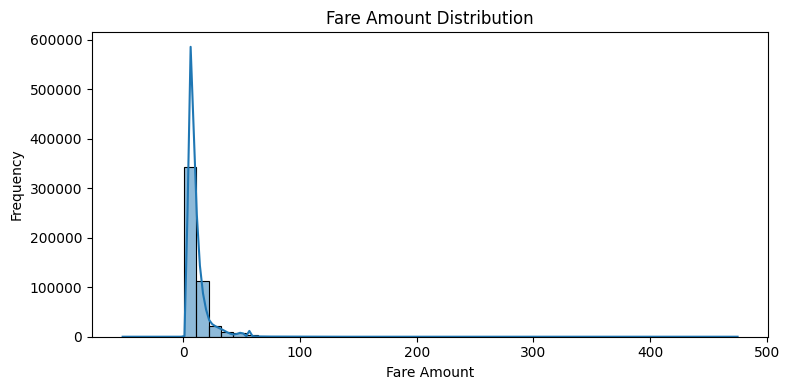

In [6]:
# üìä EDA - Before Cleaning
print_section("EDA - Before Cleaning", "Dataset shape, missing values, and stats", box_color="bold white")

# üì¶ Dataset Shape inside a panel
rows = train_df.shape[0].compute()
cols = train_df.shape[1]
print_data_shape(rows, cols)

# üö® Missing Values Summary
print_missing_summary(train_df)

# üìà Descriptive Statistics
print_describe_summary(train_df, subtitle="train_df before cleaning")

# üìâ Fare Amount Distribution
df_temp = train_df[['fare_amount']].dropna().compute()
sample = df_temp.sample(n=500_000, random_state=42) if len(df_temp) > 500_000 else df_temp

plt.figure(figsize=(8, 4))
sns.histplot(sample['fare_amount'].to_numpy(), bins=50, kde=True)
plt.title("Fare Amount Distribution")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## üßº Preprocessing & Feature Engineering

In [7]:
# ‚úÖ Convert datatypes for performance
train_df['fare_amount'] = train_df['fare_amount'].astype('float32')
for col in ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']:
    train_df[col] = train_df[col].astype('float32')
train_df['passenger_count'] = train_df['passenger_count'].astype('int8')

print_section("Datatype Optimization",
              "Converted [fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count] to efficient types for performance.",
              box_color="bold bright_green")

# ‚úÖ Extract date/time features (Fix for .str.slice error)
train_df['pickup_datetime'] = train_df['pickup_datetime'].astype('str').str.slice(0, 19).astype('datetime64[ms]')
train_df['hour'] = train_df['pickup_datetime'].dt.hour
train_df['day'] = train_df['pickup_datetime'].dt.day
train_df['month'] = train_df['pickup_datetime'].dt.month
train_df['year'] = train_df['pickup_datetime'].dt.year
train_df['weekday'] = train_df['pickup_datetime'].dt.weekday  # Monday=0

print_section("Date/Time Features",
              "Extracted new features from pickup_datetime: [hour, day, month, year, weekday]",
              box_color="bold bright_magenta")

# ‚úÖ Extra features for model performance
train_df['is_weekend'] = train_df['weekday'] >= 5
train_df['is_night'] = (train_df['hour'] >= 22) | (train_df['hour'] <= 5)
train_df['rush_hour'] = train_df['hour'].isin([7, 8, 9, 16, 17, 18])

print_section("Behavioral Features",
              "Added [is_weekend, is_night, rush_hour] to capture behavior patterns based on time.",
              box_color="bold bright_magenta")

# ‚úÖ Calculate haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

train_df['distance'] = haversine(
    train_df['pickup_latitude'], train_df['pickup_longitude'],
    train_df['dropoff_latitude'], train_df['dropoff_longitude']
)

print_section("Geospatial Feature",
              "Calculated [distance] using the haversine formula between pickup and dropoff points.",
              box_color="bold bright_magenta")

# ‚úÖ Filter invalid rows
train_df = train_df.query(
    "(fare_amount > 0) & (fare_amount < 100) & "
    "(distance > 0) & (distance < 100) & "
    "(passenger_count > 0) & (passenger_count <= 6)"
)

print_section("Data Cleaning",
              "Removed rows with invalid [fare_amount, distance, passenger_count] values.",
              box_color="bold bright_yellow")

# ‚úÖ Final Preview
print_section("Final Preprocessing Summary",
              "All features added successfully: [hour, day, month, year, weekday, is_weekend, is_night, rush_hour, distance]",
              box_color="bold bright_green")

‚ïî‚ïê Datatype Optimization ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Converted [fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude,                 ‚ïë
‚ïë passenger_count] to efficient types for performance.                                                            ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Date/Time Features ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Extracted new features from pickup_datetime: [hour, day, month, year, weekday]                                  ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Behavioral Features ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Added [is_weekend, is_night, rush_hour] to capture behavior patterns based on time.                             ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Geospatial Feature ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Calculated [distance] using the haversine formula between pickup and dropoff points.                            ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Data Cleaning ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Removed rows with invalid [fare_amount, distance, passenger_count] values.                                      ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Final Preprocessing Summary ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë All features added successfully: [hour, day, month, year, weekday, is_weekend, is_night, rush_hour, distance]   ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

## üìä EDA After Cleaning

‚ïî‚ïê EDA - After Cleaning ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Cleaned data overview, stats, and visualization                                                                 ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Cleaned Data Shape ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Rows: 53,494,406    |    Columns: 17                                                                            ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Data Preview ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë train_df after cleaning                                                                                         ‚ïë
‚ïë                                             Descriptive Statistics                                              ‚ïë
‚ïë ‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê ‚ïë
‚ïë ‚îÇ Statistic ‚îÇ fare_a ‚îÇ pickup ‚îÇ pickup ‚îÇ dropof ‚îÇ dropof ‚îÇ passen ‚îÇ hour   ‚îÇ day    ‚îÇ month  ‚îÇ year  ‚îÇ distan ‚îÇ ‚ïë
‚ïë ‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§ ‚ïë
‚ïë ‚îÇ count     ‚îÇ 53,494 ‚îÇ 53,494 ‚îÇ 53,494 ‚îÇ 53,494 ‚îÇ 53,494 ‚îÇ 53,494 ‚îÇ 53,494 ‚îÇ 53,494 ‚îÇ 53,494 ‚îÇ 53,49 ‚îÇ 53,494 ‚îÇ ‚ïë
‚ïë ‚îÇ mean      ‚îÇ 11.291 ‚îÇ -73.91 ‚îÇ 40.690 ‚îÇ -73.91 ‚îÇ 40.691 ‚îÇ 1.6918 ‚îÇ 13.511 ‚îÇ 15.715 ‚îÇ 6.2689 ‚îÇ 2,011 ‚îÇ 3.3569 ‚îÇ ‚ïë
‚ïë ‚îÇ std       ‚îÇ 9.3234 ‚îÇ 2.7986 ‚îÇ 2.6094 ‚îÇ 2.8003 ‚îÇ 2.5861 ‚îÇ 1.3075 ‚îÇ 6.5172 ‚îÇ 8.6848 ‚îÇ 3.4360 ‚îÇ 1.866 ‚îÇ 3.7125 ‚îÇ ‚ïë
‚ïë ‚îÇ min       ‚îÇ 0.0100 ‚îÇ -1,184 ‚îÇ -2,478 ‚îÇ -1,184 ‚îÇ -74.18 ‚îÇ 1.0000 ‚îÇ 0.0000 ‚îÇ 1.0000 ‚îÇ 1.0000 ‚îÇ 2,009 ‚îÇ 0.0001 ‚îÇ ‚ïë
‚ïë ‚îÇ 25%       ‚îÇ 6.0000 ‚îÇ -73.99 ‚îÇ 40.736 ‚îÇ -73.99 ‚îÇ 40.735 ‚îÇ 1.0000 ‚îÇ 9.0000 ‚îÇ 8.0000 ‚îÇ 3.0000 ‚îÇ 2,010 ‚îÇ 1.2801 ‚îÇ ‚ïë
‚ïë ‚îÇ 50%       ‚îÇ 8.5000 ‚îÇ -73.98 ‚îÇ 40.753 ‚îÇ -73.98 ‚îÇ 40.753 ‚îÇ 1.0000 ‚îÇ 14.000 ‚îÇ 16.000 ‚îÇ 6.0000 ‚îÇ 2,012 ‚îÇ 2.1797 ‚îÇ ‚ïë
‚ïë ‚îÇ 75%       ‚îÇ 12.500 ‚îÇ -73.96 ‚îÇ 40.767 ‚îÇ -73.96 ‚îÇ 40.768 ‚îÇ 2.0000 ‚îÇ 19.000 ‚îÇ 23.000 ‚îÇ 9.0000 ‚îÇ 2,013 ‚îÇ 3.9461 ‚îÇ ‚ïë
‚ïë ‚îÇ max       ‚îÇ 99.990 ‚îÇ 73.937 ‚îÇ 651.14 ‚îÇ 73.937 ‚îÇ 651.13 ‚îÇ 6.0000 ‚îÇ 23.000 ‚îÇ 31.000 ‚îÇ 12.000 ‚îÇ 2,015 ‚îÇ 99.995 ‚îÇ ‚ïë
‚ïë ‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

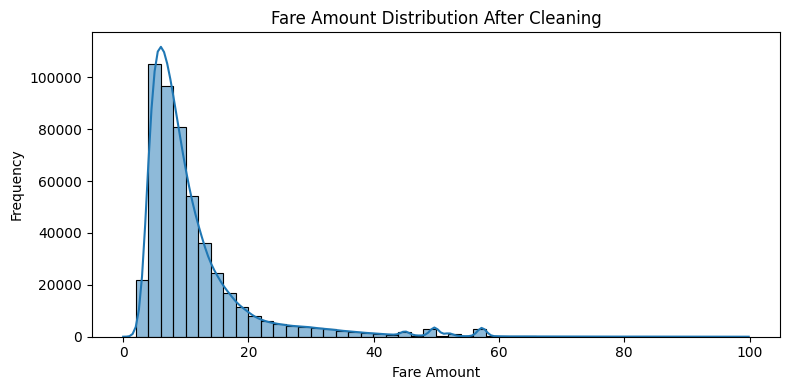

In [8]:
# üìä EDA - After Cleaning
print_section("EDA - After Cleaning", "Cleaned data overview, stats, and visualization", box_color="bold bright_magenta")

# üì¶ Dataset Shape inside a panel
rows = train_df.shape[0].compute()
cols = train_df.shape[1]
print_data_shape(rows, cols, "Cleaned Data Shape")

# üìà Descriptive Statistics Table
numeric_cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude',
                'passenger_count', 'hour', 'day', 'month', 'year', 'distance']

print_describe_summary(train_df[numeric_cols], subtitle="train_df after cleaning")

# üìâ Fare Amount Distribution Plot
df_temp = train_df[['fare_amount']].dropna().compute()
sample = df_temp.sample(n=500_000, random_state=42) if len(df_temp) > 500_000 else df_temp

plt.figure(figsize=(8, 4))
sns.histplot(sample['fare_amount'].to_numpy(), bins=50, kde=True)
plt.title("Fare Amount Distribution After Cleaning")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## üß™ Prepare Data & Train Model

In [9]:
X_train = train_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                   'passenger_count', 'hour', 'day', 'month', 'year', 'distance']].compute().to_pandas()
y_train = train_df['fare_amount'].compute().to_pandas()

In [10]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        tree_method='hist',
        device='cuda',
        objective='reg:squarederror',
        max_depth=10,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        n_estimators=500
    ))
])

pipeline.fit(X_train, y_train)
print_success("XGBoost model training completed successfully!")

‚úÖ XGBoost model training completed successfully!

In [11]:
pipeline_catboost = Pipeline([
    ('scaler', StandardScaler()),
    ('catboost', CatBoostRegressor(
        iterations=500,
        depth=10,
        learning_rate=0.05,
        loss_function='RMSE',
        task_type='GPU',
        devices='0',
        verbose=False
    ))
])

pipeline_catboost.fit(X_train, y_train)
print_success("CatBoost model training completed successfully!")

‚úÖ CatBoost model training completed successfully!

In [12]:
from cuml.ensemble import RandomForestRegressor as cuRFRegressor
X_train_cudf = cudf.DataFrame(X_train)
y_train_cudf = cudf.Series(y_train)

rf_model = cuRFRegressor(
    n_estimators=100,
    max_depth=10,
    max_features=0.8,
    random_state=42,
    n_streams=1,  # üëà for reproducibility
)

rf_model.fit(X_train_cudf, y_train_cudf)
print_success("cuML Random Forest model training completed successfully!")

‚úÖ cuML Random Forest model training completed successfully!

## üìà Visualize & Validate Results

‚ïî‚ïê Model Evaluation ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Comparing XGBoost, cuML Random Forest, and CatBoost on taxi fare prediction                                     ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ÑπÔ∏è  Preparing evaluation sample...

‚úÖ Sample prepared with 100,000 records

‚ÑπÔ∏è  Evaluating XGBoost model...

‚úÖ XGBoost evaluation completed!

‚ÑπÔ∏è  Evaluating cuML Random Forest model...

‚úÖ cuML Random Forest evaluation completed!

‚ÑπÔ∏è  Evaluating CatBoost model...

‚úÖ CatBoost evaluation completed!

‚ÑπÔ∏è  Generating prediction vs actual visualizations...

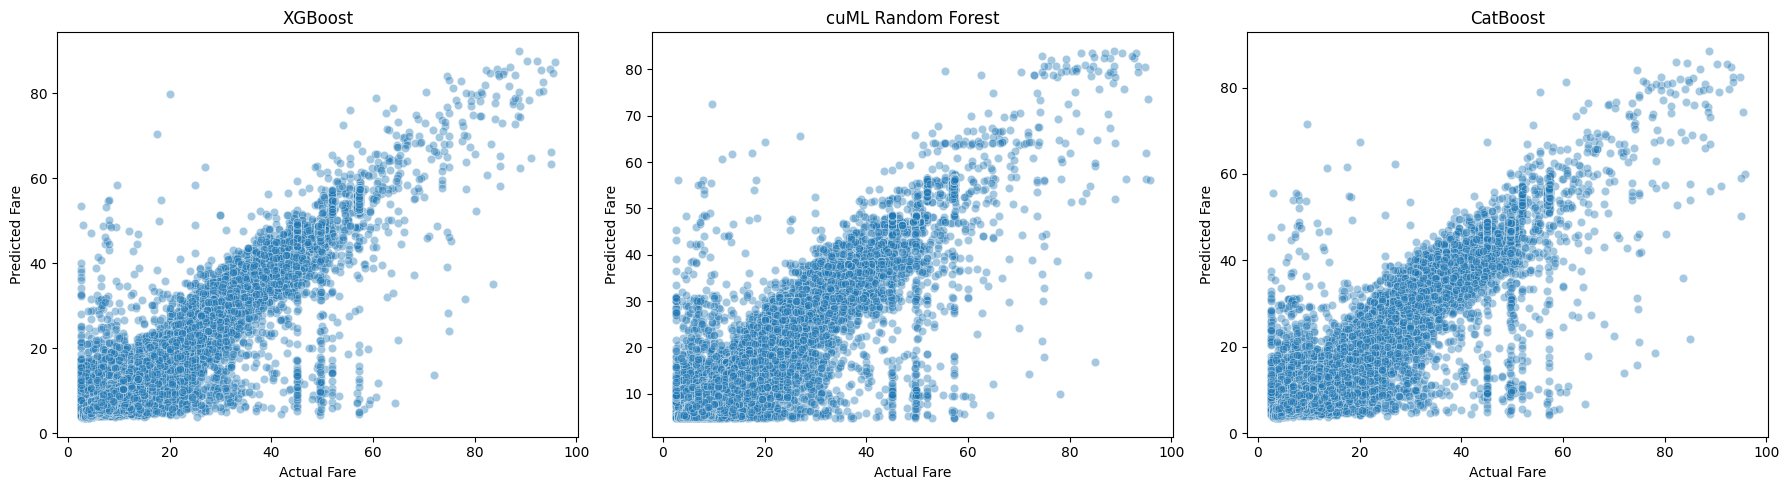

‚úÖ Visualizations created!

üìä Model Evaluation Comparison
‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë  Model   ‚îÇ RMSE ‚îÇ R¬≤ Score ‚ïë
‚ïü‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ï¢
‚ïë XGBoost  ‚îÇ 2.92 ‚îÇ  90.15%  ‚ïë
‚ïë cuML RF  ‚îÇ 3.42 ‚îÇ  86.48%  ‚ïë
‚ïë CatBoost ‚îÇ 3.13 ‚îÇ  88.68%  ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ïî‚ïê Winner Analysis ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë XGBoost wins because it achieved the lowest RMSE and the highest R¬≤, indicating it best captures the underlying ‚ïë
‚ïë patterns.                                                                                                       ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

üèÜ Model Evaluation Summary
‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Metric        ‚îÇ Value   ‚ïë
‚ïü‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ï¢
‚ïë Sample Size   ‚îÇ 100,000 ‚ïë
‚ïë Features Used ‚îÇ 10      ‚ïë
‚ïë Best Model    ‚îÇ XGBoost ‚ïë
‚ïë Best RMSE     ‚îÇ 2.92    ‚ïë
‚ïë Best R¬≤       ‚îÇ 90.15%  ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# Print a section header for the evaluation
print_section(
    "Model Evaluation",
    "Comparing XGBoost, cuML Random Forest, and CatBoost on taxi fare prediction",
    box_color="bold bright_blue"
)

# -----------------------------
# Prepare a sample to avoid overload:
print_info("Preparing evaluation sample...")
sample_df = X_train.copy()
sample_df['fare_amount'] = y_train
sample_df = sample_df.sample(n=100_000, random_state=42)
X_sample = sample_df.drop('fare_amount', axis=1)
y_sample = sample_df['fare_amount']
print_success("Sample prepared with 100,000 records")

# -----------------------------
# Model 1: XGBoost
print_info("Evaluating XGBoost model...")
booster_xgb = pipeline.named_steps['xgb'].get_booster()
scaler_xgb = pipeline.named_steps['scaler']
X_sample_scaled = scaler_xgb.transform(X_sample)
# Convert scaled data to GPU array via CuPy
X_sample_gpu = cp.array(X_sample_scaled)
# Predict using the Booster's inplace_predict and convert result to NumPy
preds_xgb = booster_xgb.inplace_predict(X_sample_gpu).get()
rmse_xgb = mean_squared_error(y_sample, preds_xgb) ** 0.5
r2_xgb = r2_score(y_sample, preds_xgb)
print_success("XGBoost evaluation completed!")

# -----------------------------
# Model 2: cuML Random Forest
print_info("Evaluating cuML Random Forest model...")
X_sample_cudf = cudf.DataFrame(X_sample)
preds_rf = rf_model.predict(X_sample_cudf).to_numpy()
rmse_rf = mean_squared_error(y_sample, preds_rf) ** 0.5
r2_rf = r2_score(y_sample, preds_rf)
print_success("cuML Random Forest evaluation completed!")

# -----------------------------
# Model 3: CatBoost
print_info("Evaluating CatBoost model...")
preds_cat = pipeline_catboost.predict(X_sample)
rmse_cat = mean_squared_error(y_sample, preds_cat) ** 0.5
r2_cat = r2_score(y_sample, preds_cat)
print_success("CatBoost evaluation completed!")

# -----------------------------
# Visualization: Create a subplot of predicted vs actual for each model
print_info("Generating prediction vs actual visualizations...")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_sample, y=preds_xgb, alpha=0.4)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('XGBoost')

plt.subplot(1, 3, 2)
sns.scatterplot(x=y_sample, y=preds_rf, alpha=0.4)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('cuML Random Forest')

plt.subplot(1, 3, 3)
sns.scatterplot(x=y_sample, y=preds_cat, alpha=0.4)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('CatBoost')

plt.tight_layout()
plt.show()
print_success("Visualizations created!")

# -----------------------------
# Gather evaluation metrics for each model
results = {
    "XGBoost": {"RMSE": rmse_xgb, "R¬≤": r2_xgb},
    "cuML RF": {"RMSE": rmse_rf, "R¬≤": r2_rf},
    "CatBoost": {"RMSE": rmse_cat, "R¬≤": r2_cat},
}

# Determine winner based on RMSE (lower is better)
winner = min(results, key=lambda k: results[k]["RMSE"])

# -----------------------------
# Create and print a Rich table comparing the models
comparison_table = Table(title="üìä Model Evaluation Comparison", title_style="bold bright_magenta", box=box.DOUBLE_EDGE)
comparison_table.add_column("Model", style="bright_white", justify="center")
comparison_table.add_column("RMSE", style="bright_white", justify="center")
comparison_table.add_column("R¬≤ Score", style="bright_white", justify="center")

for model, metrics in results.items():
    if model == winner:
        model_style = "bold bright_cyan"
    else:
        model_style = "bold bright_white"
    comparison_table.add_row(
        f"[{model_style}]{model}[/{model_style}]",
        f"[{model_style}]{metrics['RMSE']:.2f}[/{model_style}]",
        f"[{model_style}]{metrics['R¬≤']:.2%}[/{model_style}]"
    )
console.print(comparison_table)

# -----------------------------
# Dynamic explanation based on the winner
if winner == "XGBoost":
    explanation = "XGBoost wins because it achieved the lowest RMSE and the highest R¬≤, indicating it best captures the underlying patterns."
elif winner == "cuML RF":
    explanation = "cuML Random Forest wins due to its optimal balance of prediction error and variance explanation."
elif winner == "CatBoost":
    explanation = "CatBoost wins as it demonstrates superior performance in capturing complex, non-linear relationships."

console.print(Panel(f"[bold bright_cyan]{explanation}[/bold bright_cyan]", title="Winner Analysis", title_align="left", style="bold white", box=box.DOUBLE_EDGE, expand=True))

# Print a summary of the model evaluation process
stats = {
    "Sample Size": f"{len(X_sample):,}",
    "Features Used": len(X_sample.columns),
    "Best Model": winner,
    "Best RMSE": f"{results[winner]['RMSE']:.2f}",
    "Best R¬≤": f"{results[winner]['R¬≤']:.2%}"
}

print_stat_table("üèÜ Model Evaluation Summary", stats)

## üíæ Save the Model & Print Library Versions

In [17]:
# Save models to disk
print_section("Model Saving", "Saving trained models to disk for future use", box_color="bold bright_magenta")

# Save XGBoost model in ultra-compact UBJ format and gzip it
print_info("Saving lightweight XGBoost model in UBJ format...")
booster_xgb = pipeline.named_steps['xgb'].get_booster()
booster_xgb.save_model('xgb_model.ubj')

import gzip
print_info("Compressing XGBoost model...")
with open('xgb_model.ubj', 'rb') as f_in, gzip.open('xgb_model.ubj.gz', 'wb') as f_out:
    f_out.writelines(f_in)
print_success("Compressed XGBoost model saved as xgb_model.ubj.gz")

# Save cuML Random Forest model
print_info("Saving cuML Random Forest model...")
import joblib
joblib.dump(rf_model, 'cuml_rf_model.joblib')
print_success("cuML Random Forest model saved as cuml_rf_model.joblib")

# Save CatBoost model
print_info("Saving CatBoost model...")
pipeline_catboost.named_steps['catboost'].save_model('catboost_model.cbm')
print_success("CatBoost model saved as catboost_model.cbm")

# Save winner model with special prefix
if winner == "XGBoost":
    print_info("Saving winner XGBoost model in UBJ format and compressing...")
    booster_xgb.save_model('winner_xgb_model.ubj')
    with open('winner_xgb_model.ubj', 'rb') as f_in, gzip.open('winner_xgb_model.ubj.gz', 'wb') as f_out:
        f_out.writelines(f_in)
    print_success("Winner model saved as winner_xgb_model.ubj.gz")
elif winner == "cuML RF":
    print_info("Saving winner cuML Random Forest model...")
    joblib.dump(rf_model, 'winner_cuml_rf_model.joblib')
    print_success("Winner model saved as winner_cuml_rf_model.joblib")
elif winner == "CatBoost":
    print_info("Saving winner CatBoost model...")
    pipeline_catboost.named_steps['catboost'].save_model('winner_catboost_model.cbm')
    print_success("Winner model saved as winner_catboost_model.cbm")

# Print package versions for reproducibility
print_section("Package Versions", "Recording package versions for reproducibility", box_color="bold bright_cyan")
import subprocess

def get_package_version(package):
    result = subprocess.run(['pip', 'freeze'], capture_output=True, text=True)
    packages = result.stdout.split('\n')
    for p in packages:
        if package in p:
            return p
    return f"{package}: Not found"

xgboost_version = get_package_version('xgboost')
dask_version = get_package_version('dask')
cudf_version = get_package_version('cudf')
catboost_version = get_package_version('catboost')
cuml_version = get_package_version('cuml')

version_table = Table(title="üì¶ Package Versions", title_style="bold bright_cyan", box=box.DOUBLE_EDGE)
version_table.add_column("Package", style="bright_white", justify="right")
version_table.add_column("Version", style="bold bright_green", justify="left")

version_table.add_row("XGBoost", f"[bold bright_yellow]{xgboost_version}[/bold bright_yellow]")
version_table.add_row("Dask", f"[bold bright_yellow]{dask_version}[/bold bright_yellow]")
version_table.add_row("cuDF", f"[bold bright_yellow]{cudf_version}[/bold bright_yellow]")
version_table.add_row("CatBoost", f"[bold bright_yellow]{catboost_version}[/bold bright_yellow]")
version_table.add_row("cuML", f"[bold bright_yellow]{cuml_version}[/bold bright_yellow]")

console.print(version_table)

‚ïî‚ïê Model Saving ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Saving trained models to disk for future use                                                                    ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

‚ÑπÔ∏è  Saving lightweight XGBoost model in UBJ format...

‚ÑπÔ∏è  Compressing XGBoost model...

‚úÖ Compressed XGBoost model saved as xgb_model.ubj.gz

‚ÑπÔ∏è  Saving cuML Random Forest model...

‚úÖ cuML Random Forest model saved as cuml_rf_model.joblib

‚ÑπÔ∏è  Saving CatBoost model...

‚úÖ CatBoost model saved as catboost_model.cbm

‚ÑπÔ∏è  Saving winner XGBoost model in UBJ format and compressing...

‚úÖ Winner model saved as winner_xgb_model.ubj.gz

‚ïî‚ïê Package Versions ‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë Recording package versions for reproducibility                                                                  ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù

      üì¶ Package Versions       
‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë  Package ‚îÇ Version           ‚ïë
‚ïü‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ï¢
‚ïë  XGBoost ‚îÇ xgboost==2.1.4    ‚ïë
‚ïë     Dask ‚îÇ dask==2024.12.1   ‚ïë
‚ïë     cuDF ‚îÇ cudf-cu12==25.2.0 ‚ïë
‚ïë CatBoost ‚îÇ catboost==1.2.8   ‚ïë
‚ïë     cuML ‚îÇ cuml-cu12==25.2.1 ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù